# Classification Model Training
## CRISP-DM Phase 4: Modeling - Cancellation Prediction

This notebook trains and evaluates classification models to predict booking cancellations.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import sys
sys.path.insert(0, '../src')

from preprocessing import load_data, clean_data, engineer_features, prepare_classification_data
from classification_model import CancellationClassifier

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Load and Prepare Data

In [3]:
# Load and preprocess
df = load_data('../data/raw/hotel_bookings.csv')
df = clean_data(df)
df = engineer_features(df)

# Prepare classification data
X_train, X_test, y_train, y_test, feature_names = prepare_classification_data(df)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTarget distribution (train):")
print(y_train.value_counts(normalize=True))

Training set: (94404, 26)
Test set: (23602, 26)

Target distribution (train):
is_canceled
0    0.629253
1    0.370747
Name: proportion, dtype: float64


## 2. Train Models

In [4]:
# Train Random Forest
print("Training Random Forest...")
rf_clf = CancellationClassifier(model_type='random_forest')
rf_clf.train(X_train, y_train)

# Evaluate
print("\n" + "="*50)
print("Random Forest Results:")
rf_metrics = rf_clf.evaluate(X_test, y_test)

Training Random Forest...

Random Forest Results:

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.96      0.87     14852
           1       0.89      0.60      0.71      8750

    accuracy                           0.82     23602
   macro avg       0.84      0.78      0.79     23602
weighted avg       0.83      0.82      0.81     23602


ROC-AUC: 0.8929


In [5]:
# Train XGBoost
print("Training XGBoost...")
xgb_clf = CancellationClassifier(model_type='xgboost')
xgb_clf.train(X_train, y_train)

# Evaluate
print("\n" + "="*50)
print("XGBoost Results:")
xgb_metrics = xgb_clf.evaluate(X_test, y_test)

Training XGBoost...


c:\Users\ngoqu\anaconda3\envs\hotel_ml_project\Lib\site-packages\xgboost\training.py:199: UserWarning: [10:59:00] WARNING: D:\bld\xgboost-split_1768313916136\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.82      0.94      0.87     14852
           1       0.86      0.65      0.74      8750

    accuracy                           0.83     23602
   macro avg       0.84      0.79      0.80     23602
weighted avg       0.83      0.83      0.82     23602


ROC-AUC: 0.8986


## 3. Model Comparison

In [6]:
# Compare models
comparison = pd.DataFrame({
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics
}).T

comparison.style.background_gradient(cmap='Greens', axis=0)

,accuracy,precision,recall,f1,roc_auc
Random Forest,0.821922,0.887506,0.595086,0.712458,0.892855
XGBoost,0.828574,0.855287,0.647086,0.736760,0.898581


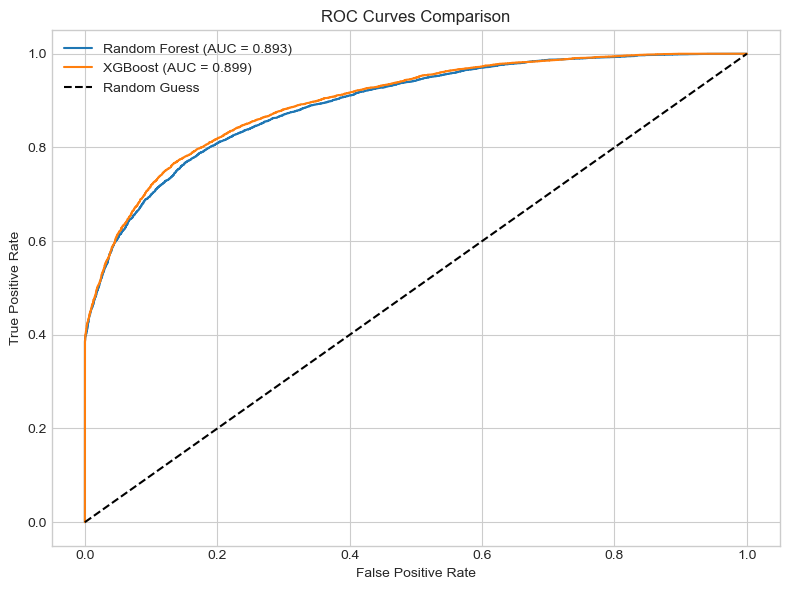

Saved: ../charts/roc_curves.png


In [11]:
# ROC Curves
fig, ax = plt.subplots(figsize=(8, 6))

for name, clf in [('Random Forest', rf_clf), ('XGBoost', xgb_clf)]:
    y_proba = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves Comparison')
ax.legend()
plt.tight_layout()
plt.savefig('../charts/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: ../charts/roc_curves.png')

## 4. Feature Importance

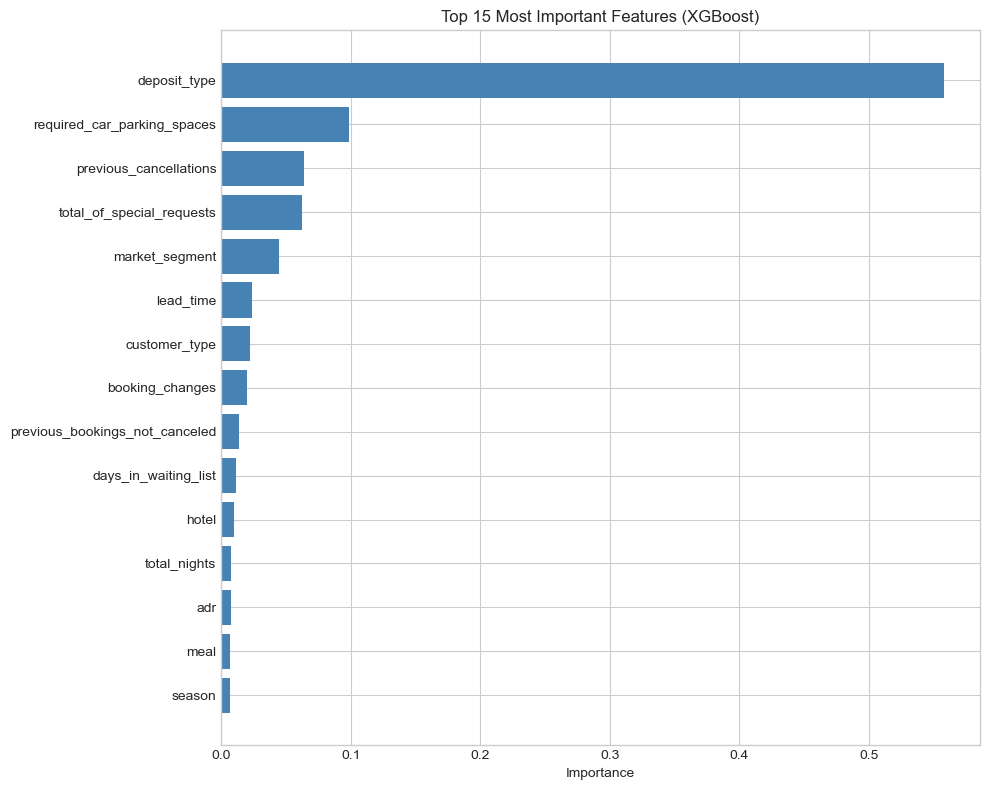

Saved: ../charts/feature_importance.png


In [12]:
# XGBoost feature importance
importance = xgb_clf.get_feature_importance()

plt.figure(figsize=(10, 8))
top_features = importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../charts/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: ../charts/feature_importance.png')

## 5. Confusion Matrix

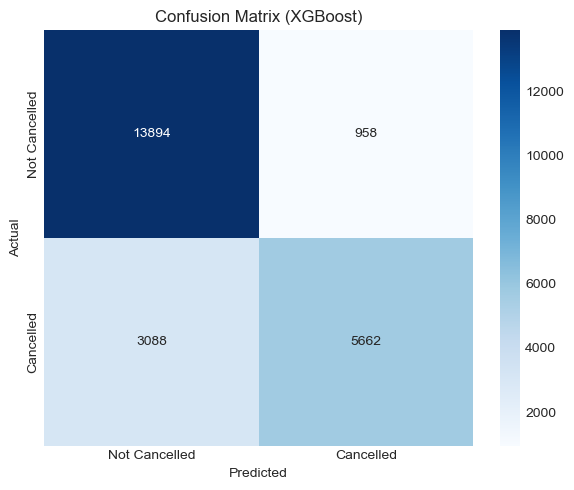

Saved: ../charts/confusion_matrix.png


In [13]:
# XGBoost confusion matrix
y_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Cancelled', 'Cancelled'],
            yticklabels=['Not Cancelled', 'Cancelled'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.tight_layout()
plt.savefig('../charts/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved: ../charts/confusion_matrix.png')

## 6. Save Best Model

In [10]:
# Save the best performing model (XGBoost)
xgb_clf.save('../models/cancellation_model.pkl')

print("Model saved successfully!")
print(f"\nFinal XGBoost Metrics:")
for metric, value in xgb_metrics.items():
    print(f"  {metric}: {value:.4f}")

Model saved to ../models/cancellation_model.pkl
Model saved successfully!

Final XGBoost Metrics:
  accuracy: 0.8286
  precision: 0.8553
  recall: 0.6471
  f1: 0.7368
  roc_auc: 0.8986
